In [53]:
import requests
import dataset
import sqlite3
import pandas as pd
import seaborn as sns

In [2]:
import csv

In [3]:
pip install -U pip

Note: you may need to restart the kernel to use updated packages.


In [4]:
import requests

In [5]:
import re

In [6]:
from bs4 import BeautifulSoup

In [7]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install dataset

Note: you may need to restart the kernel to use updated packages.


In [9]:
#from urllib.parse import urljoin, urldefrag

In [10]:
import dataset

In [11]:
#from joblib import Parallel, delayed

In [12]:
from datetime import datetime

In [13]:
from urllib.parse import urljoin, urlparse

In [14]:
db = dataset.connect("sqlite:///books.db")# to store the book in sqlite

In [15]:
db

<Database(sqlite:///books.db)>

In [16]:
base_url = 'https://books.toscrape.com/'

In [17]:
base_url

'https://books.toscrape.com/'

In [20]:
def scrape_books(html_soup, url):
    for book in html_soup.select('article.product_pod'):
        # Firstly, we'll save the books url
        book_url = book.find('h3').find('a').get('href')
        book_url = urljoin(url, book_url)
        path = urlparse(book_url).path
        book_id = path.split('/')[2]
        db['books'].upsert({'book_id' : book_id,
                            'last_seen' : datetime.now()
                           }, ['book_id'])
# Upsert endeavors to update 1st and then insert instead

In [21]:
def scrape_book(html_soup, book_id):
    main = html_soup.find(class_='product_main')
    book = {}
    book['book_id'] = book_id
    book['title'] = main.find('h1').get_text(strip=True)
    book['price'] = main.find(class_='price_color').get_text(strip=True)
    book['stock'] = main.find(class_='availability').get_text(strip=True)
    book['rating'] = ' '.join(main.find(class_='star-rating') \
                              .get('class')).replace('star-rating', '').strip()
    book['img'] = html_soup.find(class_='thumbnail').find('img').get('src')
    desc = html_soup.find(id='product_description')
    book['description'] = ''
    if desc:
        book['description'] = desc.find_next_sibling('p') \
                                  .get_text(strip=True)
        info_table = html_soup.find(string='Product Information').find_next('table')
        for row in info_table.find_all('tr'):
            header = row.find('th').get_text(strip=True)
            # Since we have to use the header as a column, we clean it a bit to ensure that sqlite accept it
            header = re.sub('[^a-zA-Z]+', '_', header)
            value = row.find('td').get_text(strip=True)
            book[header] = value
            db['book_info'].upsert(book, ['book_id'])

In [22]:
#now is to scrap the pages in the cata
url = base_url
inp = input('Do you wish to re-scrape the catalogue (y/n)? ')#automatically scrapped d page
while True and inp == 'y':
    print('scraping page:', url)    
    r = requests.get(url)
    html_soup = BeautifulSoup(r.text, 'html.parser')    
    scrape_books(html_soup, url)    
    # Is there a next page?
    next_a = html_soup.select('li.next > a')
    if not next_a or not next_a[0].get('href'):
        break    
    url = urljoin(url, next_a[0].get('href'))
    # Now scrape book by book, starting with the first
books = db['books'].find(order_by=['last_seen'])
for book in books:    
    book_id = book['book_id']    
    book_url = base_url + 'catalogue/{}'.format(book_id)
    print('Now scraping book:', book_url)    
    r = requests.get(book_url)    
    r.encoding = 'utf-8'    
    html_soup = BeautifulSoup(r.text, 'html.parser')
    scrape_book(html_soup, book_id)    
    # Update the last seen timestamp    
    db['books'].upsert({'book_id' : book_id,
                              'last_seen' : datetime.now()
                             }, ['book_id'])

Do you wish to re-scrape the catalogue (y/n)? y
Now scraping page: https://books.toscrape.com/
Now scraping page: https://books.toscrape.com/catalogue/page-2.html
Now scraping page: https://books.toscrape.com/catalogue/page-3.html
Now scraping page: https://books.toscrape.com/catalogue/page-4.html
Now scraping page: https://books.toscrape.com/catalogue/page-5.html
Now scraping page: https://books.toscrape.com/catalogue/page-6.html
Now scraping page: https://books.toscrape.com/catalogue/page-7.html
Now scraping page: https://books.toscrape.com/catalogue/page-8.html
Now scraping page: https://books.toscrape.com/catalogue/page-9.html
Now scraping page: https://books.toscrape.com/catalogue/page-10.html
Now scraping page: https://books.toscrape.com/catalogue/page-11.html
Now scraping page: https://books.toscrape.com/catalogue/page-12.html
Now scraping page: https://books.toscrape.com/catalogue/page-13.html
Now scraping page: https://books.toscrape.com/catalogue/page-14.html
Now scraping pag

In [ ]:
books

In [ ]:
print(books)

In [23]:
books

In [26]:
connection = sqlite3.connect("books.db")

In [27]:
cursor = connection.cursor()

In [28]:
query= 'SELECT * FROM book_info;'

In [29]:
cursor.execute(query)

In [30]:
output = cursor.fetchall()

In [32]:
book=pd.read_sql_query(query, connection)

In [33]:
book

,id,book_id,title,price,stock,rating,img,description,UPC,Product_Type,Price_excl_tax_,Price_incl_tax_,Tax,Availability,Number_of_reviews
0,1,a-light-in-the-attic_1000,A Light in the Attic,£51.77,In stock (22 available),Three,../../media/cache/fe/72/fe72f0532301ec28892ae7...,It's hard to imagine a world without A Light i...,a897fe39b1053632,Books,£51.77,£51.77,£0.00,In stock (22 available),0
1,2,tipping-the-velvet_999,Tipping the Velvet,£53.74,In stock (20 available),One,../../media/cache/08/e9/08e94f3731d7d6b760dfbf...,"""Erotic and absorbing...Written with starling ...",90fa61229261140a,Books,£53.74,£53.74,£0.00,In stock (20 available),0
2,3,soumission_998,Soumission,£50.10,In stock (20 available),One,../../media/cache/ee/cf/eecfe998905e455df12064...,"Dans une France assez proche de la nôtre, un h...",6957f44c3847a760,Books,£50.10,£50.10,£0.00,In stock (20 available),0
3,4,sharp-objects_997,Sharp Objects,£47.82,In stock (20 available),Four,../../media/cache/c0/59/c05972805aa7201171b8fc...,"WICKED above her hipbone, GIRL across her hear...",e00eb4fd7b871a48,Books,£47.82,£47.82,£0.00,In stock (20 available),0
4,5,sapiens-a-brief-history-of-humankind_996,Sapiens: A Brief History of Humankind,£54.23,In stock (20 available),Five,../../media/cache/ce/5f/ce5f052c65cc963cf4422b...,From a renowned historian comes a groundbreaki...,4165285e1663650f,Books,£54.23,£54.23,£0.00,In stock (20 available),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,994,beyond-good-and-evil_6,Beyond Good and Evil,£43.38,In stock (1 available),One,../../media/cache/d1/7f/d17f326e3fcaf84c37d6d5...,Friedrich Nietzsche's Beyond Good and Evil is ...,08672cd59171d5e4,Books,£43.38,£43.38,£0.00,In stock (1 available),0
994,995,ajin-demi-human-volume-1-ajin-demi-human-1_4,"Ajin: Demi-Human, Volume 1 (Ajin: Demi-Human #1)",£57.06,In stock (1 available),Four,../../media/cache/30/98/309814b6eeba469f4c7411...,High school student Kei Nagai is struck dead i...,bfd5e1701c862ac3,Books,£57.06,£57.06,£0.00,In stock (1 available),0
995,996,a-spys-devotion-the-regency-spies-of-london-1_3,A Spy's Devotion (The Regency Spies of London #1),£16.97,In stock (1 available),Five,../../media/cache/f9/6b/f96b60a7614c4e3e868b82...,"In England’s Regency era, manners and elegance...",19fec36a1dfb4c16,Books,£16.97,£16.97,£0.00,In stock (1 available),0
996,997,1st-to-die-womens-murder-club-1_2,1st to Die (Women's Murder Club #1),£53.98,In stock (1 available),One,../../media/cache/f6/8e/f68e6ae2f9da04fccbde84...,"James Patterson, bestselling author of the Ale...",f684a82adc49f011,Books,£53.98,£53.98,£0.00,In stock (1 available),0


In [34]:
#simple celaning process
book.to_csv('book_info.csv')

In [35]:
book['price'] = book['price'].str.replace("£","")

In [36]:
book['price'] = book['price'].str.replace("£","")

In [37]:
book['Price_excl_tax_'] = book['Price_excl_tax_'].str.replace("£","")

In [38]:
book['Price_incl_tax_'] = book['Price_incl_tax_'].str.replace("£","")

In [39]:
book['Tax'] = book['Tax'].str.replace("£","")

In [40]:
book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 998 non-null    int64 
 1   book_id            998 non-null    object
 2   title              998 non-null    object
 3   price              998 non-null    object
 4   stock              998 non-null    object
 5   rating             998 non-null    object
 6   img                998 non-null    object
 7   description        998 non-null    object
 8   UPC                998 non-null    object
 9   Product_Type       998 non-null    object
 10  Price_excl_tax_    998 non-null    object
 11  Price_incl_tax_    998 non-null    object
 12  Tax                998 non-null    object
 13  Availability       998 non-null    object
 14  Number_of_reviews  998 non-null    object
dtypes: int64(1), object(14)
memory usage: 117.1+ KB


In [41]:
book

,id,book_id,title,price,stock,rating,img,description,UPC,Product_Type,Price_excl_tax_,Price_incl_tax_,Tax,Availability,Number_of_reviews
0,1,a-light-in-the-attic_1000,A Light in the Attic,51.77,In stock (22 available),Three,../../media/cache/fe/72/fe72f0532301ec28892ae7...,It's hard to imagine a world without A Light i...,a897fe39b1053632,Books,51.77,51.77,0.00,In stock (22 available),0
1,2,tipping-the-velvet_999,Tipping the Velvet,53.74,In stock (20 available),One,../../media/cache/08/e9/08e94f3731d7d6b760dfbf...,"""Erotic and absorbing...Written with starling ...",90fa61229261140a,Books,53.74,53.74,0.00,In stock (20 available),0
2,3,soumission_998,Soumission,50.10,In stock (20 available),One,../../media/cache/ee/cf/eecfe998905e455df12064...,"Dans une France assez proche de la nôtre, un h...",6957f44c3847a760,Books,50.10,50.10,0.00,In stock (20 available),0
3,4,sharp-objects_997,Sharp Objects,47.82,In stock (20 available),Four,../../media/cache/c0/59/c05972805aa7201171b8fc...,"WICKED above her hipbone, GIRL across her hear...",e00eb4fd7b871a48,Books,47.82,47.82,0.00,In stock (20 available),0
4,5,sapiens-a-brief-history-of-humankind_996,Sapiens: A Brief History of Humankind,54.23,In stock (20 available),Five,../../media/cache/ce/5f/ce5f052c65cc963cf4422b...,From a renowned historian comes a groundbreaki...,4165285e1663650f,Books,54.23,54.23,0.00,In stock (20 available),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,994,beyond-good-and-evil_6,Beyond Good and Evil,43.38,In stock (1 available),One,../../media/cache/d1/7f/d17f326e3fcaf84c37d6d5...,Friedrich Nietzsche's Beyond Good and Evil is ...,08672cd59171d5e4,Books,43.38,43.38,0.00,In stock (1 available),0
994,995,ajin-demi-human-volume-1-ajin-demi-human-1_4,"Ajin: Demi-Human, Volume 1 (Ajin: Demi-Human #1)",57.06,In stock (1 available),Four,../../media/cache/30/98/309814b6eeba469f4c7411...,High school student Kei Nagai is struck dead i...,bfd5e1701c862ac3,Books,57.06,57.06,0.00,In stock (1 available),0
995,996,a-spys-devotion-the-regency-spies-of-london-1_3,A Spy's Devotion (The Regency Spies of London #1),16.97,In stock (1 available),Five,../../media/cache/f9/6b/f96b60a7614c4e3e868b82...,"In England’s Regency era, manners and elegance...",19fec36a1dfb4c16,Books,16.97,16.97,0.00,In stock (1 available),0
996,997,1st-to-die-womens-murder-club-1_2,1st to Die (Women's Murder Club #1),53.98,In stock (1 available),One,../../media/cache/f6/8e/f68e6ae2f9da04fccbde84...,"James Patterson, bestselling author of the Ale...",f684a82adc49f011,Books,53.98,53.98,0.00,In stock (1 available),0


In [42]:
pd.set_option('display.max_colwidth', None)

In [66]:
#summary statistics of price. The average price is 35euro with a far standard deviation from the center of 14euro.
#The maximum price is 59 euro and the minimum is 10 euro. It also include the median price, the Q1 and Q3 price values.
book["price"].describe()

count   998.000
mean     35.053
std      14.446
min      10.000
25%      22.102
50%      35.980
75%      47.407
max      59.990
Name: price, dtype: float64

In [46]:
book.describe()

,id
count,998.000
mean,499.500
std,288.242
min,1.000
25%,250.250
50%,499.500
75%,748.750
max,998.000


In [50]:
#the counts of books by rating.
#most of the books has just one ratings
book['rating'].value_counts()

One      225
Three    202
Two      196
Five     196
Four     179
Name: rating, dtype: int64

In [51]:
#the percentage rating of the books.
pd.crosstab(book['rating'], columns = 'counts',normalize=True)

col_0,counts
rating,
Five,0.196
Four,0.179
One,0.225
Three,0.202
Two,0.196


<AxesSubplot:xlabel='rating', ylabel='count'>

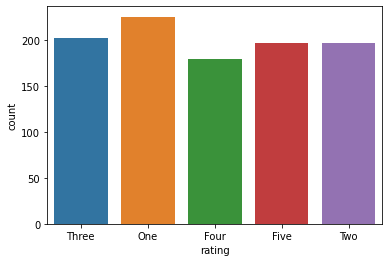

In [54]:
#the plot-counts of books by rating
sns.countplot(x = 'rating', data = book)

In [57]:
book['price'] = book.price.astype(float)

<AxesSubplot:xlabel='price', ylabel='rating'>

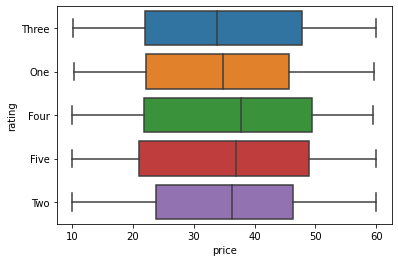

In [59]:
#the boxplot showing the effect of price on rating
sns.boxplot(x = 'price', y='rating', data = book)